# Analog: Ana(lyzing) Log(s)

**TODO**: Explore content type humans vs bots

**TODO**: Explore referrals

This notebook uses analog to analyze access logs. It highlights analog's fluent
API, which composes complex queries on a Pandas dataframe with the log data from
many simple operations. That is, after all, analog's raison d'être.

As a result, this notebook glosses over significant features that produce this
dataframe in the first place. Notably:

 1. Parse monthly access logs to convert unstructured text into structured data;
 2. Add derrived columns such as `cool_path` or `status_class` that simplify
    analysis;
 3. Correlate some columns with other databases, notably for domain
    names, IP locations, and user agent classification.

To avoid reprocessing an ever growing amount of log data, analog processes each
monthly access log on its own, saving the resulting monthly dataframes as
individual Parquet files. It then combine all dataframes into a single one and
saves that as a Parquet file, too. A JSON sidecar file contains summary
statistics, the so-called *coverage*.

Alas, during development of this library, bugs and newly added features
frequently required rebuilding all dataframes from scratch. By far the slowest
operation when doing so are DNS lookups. Consequently, analog caches them in a
`hostnames.json` file, which speeds up repeated ingestion from several minutes
down to a few seconds.

## Update Log Dataframe

In [1]:
from analog.analyzer import analyze, merge
from analog.data_manager import latest_log_data

df, cover = latest_log_data("data")
df.info(verbose=True, memory_usage=True)

[INFO] Load existing log frame 'data/apparebit.com-2018-07-2022-07.parquet'
[INFO] Validating log frame 'data/apparebit.com-2018-07-2022-07.parquet'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227553 entries, 0 to 227552
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   client_address    227553 non-null  string             
 1   timestamp         227553 non-null  datetime64[ns, UTC]
 2   method            227553 non-null  category           
 3   path              227553 non-null  string             
 4   query             3226 non-null    string             
 5   protocol          227553 non-null  category           
 6   status            227553 non-null  int16              
 7   size              227553 non-null  int32              
 8   referrer          100860 non-null  string             
 9   user_agent        224065 non-null  string             
 10  server_name       202518 non-null  string             
 11  server_address    202518 non-null  string             
 12  content_type      227553 non-null  category 

## Analyze Log Dataframe

The rest of the notebook explores several metrics via analog's fluent analysis
API.

### Monthly Page Views

[apparebit.com](https://apparebit.com) utilizes commercially licensed fonts.
Thankfully, all licenses are perpetual, i.e., don't require regular renewal and
hence repeated payment. However, they do impose upper limits on the number of
page views per month. So, let's calculate just that and then plot the result.

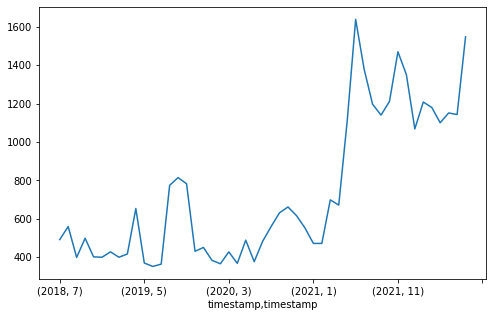

In [2]:
page_views = (
    analyze(df, cover)
    .only.humans()
    .only.get()
    .only.markup()
    .only.successful()
)

# Display graph for page views per month.
page_views.monthly.requests().then_plot(figsize=(8,5))

### Top 20 Most Popular Pages Last Month

We build on page views, i.e., successful requests for HTML presumably made by
humans.

In [3]:

# Also print table with 20 most popular paths for last month.
page_views.over.last_month().value_counts("cool_path").then_print(20)

/                                        745
/blog/2019/i-feel-love                   201
/blog/2021/game-of-thrones               150
/blog                                     62
/features/ubu-trump                       44
/about/apparebit                          38
/about/robert-grimm                       30
/about/privacy                            28
/blog/2022/wrong-impression               27
/blog/2022/mapping-package-management     24
/about/robert-grimm/with-halo             24
/features/breath                          22
/features/do-you-be                       21
/features/candy-or-bust                   20
/blog/2018/the-donald-is-in-love          20
/blog/2022/zuckerberg-lies                19
/blog/2016/hopelessness                   19
/features/candy-or-bust/voyeur            17
/blog/2022/new-map-layers                 17
/blog/2021/lets-try-again                 16
Name: cool_path, dtype: Int64


### Top 20 Most Popular Pages Last Year

We again build on page views. This is a minor variation of the previous metric.

In [4]:
page_views.over.last_year().value_counts("cool_path").then_print(20)

/                                     7400
/blog/2021/game-of-thrones            1765
/blog                                  759
/blog/2019/i-feel-love                 426
/about/robert-grimm                    409
/about/apparebit                       407
/blog/2022/wrong-impression            372
/about/privacy                         354
/features/ubu-trump                    347
/blog/2016/hopelessness                303
/about/robert-grimm/with-halo          300
/features/candy-or-bust                297
/features/do-you-be                    259
/features/candy-or-bust/voyeur         248
/blog/2022/zuckerberg-lies             246
/blog/2019/a-frivolous-perspective     228
/blog/2018/utopia-where-we-find-it     222
/blog/2018/the-donald-is-in-love       188
/blog/2021/lets-try-again               66
/features/breath                        51
Name: cool_path, dtype: Int64


### Monthly Breakdown of Status Codes

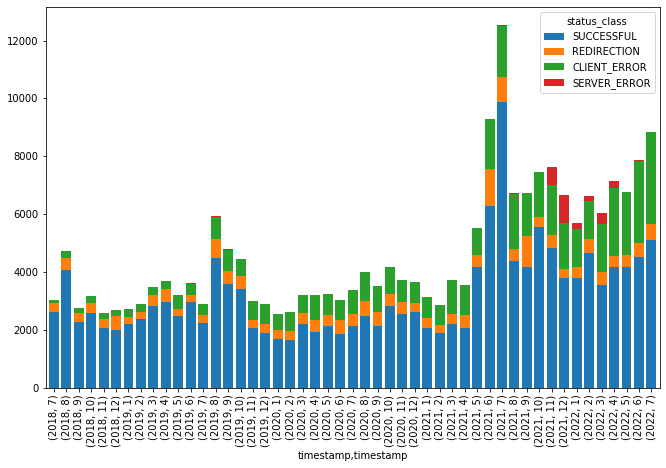

In [5]:
(
    analyze(df, cover)
    .monthly.status_classes()
    .then_plot(kind='bar', stacked=True, width=0.8, figsize=(11,7))
)

### Top 20 Paths Not Found During Last Year

In [7]:
(
    analyze(df, cover)
    .only.not_found()
    .over.last_year()
    .value_counts("path")
    .then_print(20)
)

/favicon.ico                               673
/ads.txt                                   563
/th1s_1s_a_4o4.html                        358
//cms/wp-includes/wlwmanifest.xml          306
//site/wp-includes/wlwmanifest.xml         306
//test/wp-includes/wlwmanifest.xml         306
//wp1/wp-includes/wlwmanifest.xml          306
//wordpress/wp-includes/wlwmanifest.xml    303
//wp/wp-includes/wlwmanifest.xml           302
//web/wp-includes/wlwmanifest.xml          300
//shop/wp-includes/wlwmanifest.xml         299
//2019/wp-includes/wlwmanifest.xml         297
//blog/wp-includes/wlwmanifest.xml         287
//wp2/wp-includes/wlwmanifest.xml          284
//sito/wp-includes/wlwmanifest.xml         284
//news/wp-includes/wlwmanifest.xml         280
//website/wp-includes/wlwmanifest.xml      279
//wp-includes/wlwmanifest.xml              183
//2018/wp-includes/wlwmanifest.xml         166
//media/wp-includes/wlwmanifest.xml        166
Name: path, dtype: Int64


### Robot Client Errors Per Month

We would expect that robots know what they are looking for and hence have a much
smaller error rate than human traffic. Let's check that hypothesis.

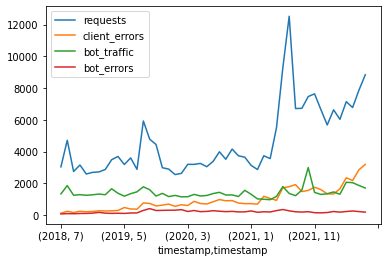

In [10]:
analog = analyze(df, cover)

# Each phrase has its own dataframe. So we can reuse previously computed phrases.
bot_traffic = analog.only.bots()
bot_errors = bot_traffic.only.client_error()
traffic = analog
client_errors = traffic.only.client_error()

# Finish each series.
labels = ["requests", "client_errors", "bot_traffic", "bot_errors"]
series = [traffic, client_errors, bot_traffic, bot_errors]
requests = merge({n: s.monthly.requests() for n, s in zip(labels, series)})
requests.as_is.then_plot()